In [1]:

library(rhdf5)
library(DESeq2)

library(biomaRt)
library(RColorBrewer)
library(VennDiagram)
library(dplyr)
library(ggrepel)
suppressPackageStartupMessages(library(ComplexHeatmap))
library(ggplot2)
library(fgsea)
library(msigdbr)
# library(ggforce)
library(patchwork)
library(tidyverse)
library(viridis)
library(cowplot)
library(EnhancedVolcano)
library(tximport)
library(enrichR)


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!



Gene lists from literature

In [2]:
msig_df <- msigdbr(species = "Mus musculus")
test <- msig_df[grep("GSE23321", msig_df$gs_name ), ]



In [3]:
library(RColorBrewer)
library(circlize)

circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [4]:
# qstem score used in https://www.nature.com/articles/s41590-022-01171-9#MOESM4
# positive and negative association
qstem_p <- as.vector(as.matrix(read.table(file.path("/net/shendure/vol8/projects/scifate_abadiek/Tcf7_genomics/Tcf7_RNA_analysis/gene_lists", "qstem_pos.txt"))))
qstem_n <- as.vector(as.matrix(read.table(file.path("/net/shendure/vol8/projects/scifate_abadiek/Tcf7_genomics/Tcf7_RNA_analysis/gene_lists", "qstem_neg.txt"))))
gs_names <-  as.vector(as.matrix(read.table(file.path("/net/shendure/vol8/projects/scifate_abadiek/Tcf7_genomics/Tcf7_RNA_analysis/gene_lists", "msigdbr_gs_name.txt"))))
gs_names_gsea <- as.vector(as.matrix(read.table(file.path("/net/shendure/vol8/projects/scifate_abadiek/Tcf7_genomics/Tcf7_RNA_analysis/gene_lists", "msigdbr_gs_name_gsea.txt"))))

# msigdbr
# get gene lists
msig_df <- msigdbr(species = "Mus musculus", category = "C7")
msig_df <- msig_df[which(msig_df$gs_name %in% gs_names), ]
# msig_df <- msig_df[grep("UP", msig_df$gs_name ), ]

msig_df_GR_EFFvMEM_UP <- msig_df[grep("GOLDRATH_EFF_VS_MEMORY_CD8_TCELL_UP", msig_df$gs_name ), ] # Goldrath 
msig_df_GR_EFFvMEM_DN <- msig_df[grep("GOLDRATH_EFF_VS_MEMORY_CD8_TCELL_DN", msig_df$gs_name ), ] # Goldrath 
msig_df_SK_D8_EFFvMEM_UP <- msig_df[grep("KAECH_DAY8_EFF_VS_MEMORY_CD8_TCELL_UP", msig_df$gs_name ), ] #Kaech D8
msig_df_SK_D8_EFFvMEM_DN <- msig_df[grep("KAECH_DAY8_EFF_VS_MEMORY_CD8_TCELL_DN", msig_df$gs_name ), ] #Kaech D8
msig_df_SK_D15_EFFvMEM_UP <- msig_df[grep("KAECH_DAY15_EFF_VS_MEMORY_CD8_TCELL_UP", msig_df$gs_name ), ] #Kaech D15
msig_df_SK_D15_EFFvMEM_DN <- msig_df[grep("KAECH_DAY15_EFF_VS_MEMORY_CD8_TCELL_DN", msig_df$gs_name ), ] #Kaech D15




In [5]:
EffvMem_UP <- unique(c(msig_df_GR_EFFvMEM_UP$gene_symbol, msig_df_SK_D8_EFFvMEM_UP$gene_symbol))
EffvMem_DN <- unique(c(msig_df_GR_EFFvMEM_DN$gene_symbol, msig_df_SK_D8_EFFvMEM_DN$gene_symbol))
gs_names_gsea <- as.vector(as.matrix(read.table(file.path("/net/shendure/vol8/projects/scifate_abadiek/Tcf7_genomics/Tcf7_RNA_analysis/gene_lists", "msigdbr_gs_name_gsea.txt"))))


Insert kallisto abundances for DESeq2 analysis using tximport

In [6]:
RNA_path <- "/net/shendure/vol8/projects/scifate_abadiek/Tcf7_genomics/Tcf7_RNA_analysis"
main_dir <- "/net/shendure/vol8/projects/scifate_abadiek/Tcf7_genomics/Tcf7_RNA_analysis/kallisto"
sample_id <- dir(file.path(main_dir,"outs"))
sample_dir <- file.path(main_dir, "outs", sample_id)
files = file.path(sample_dir, "abundance.h5")

In [7]:
# remove LL files 
LL_ind <- grep("low_low", files)
files <- files[-LL_ind]
sample_id <- sample_id[-LL_ind]

# load ensemble to gene map generated from reference transcriptome
# ensemble2gene_raw <- read.table(file.path(main_dir, "transcripts_to_genes.txt"))
ensemble2gene <- read.table(file.path(main_dir, "transcripts_to_genes.txt"))
transcript_id <- ensemble2gene$V1
gene <- ensemble2gene$V3
ensemble2gene <- data.frame(transcript_id, gene)

# counts matrix from kallisto abundance files
txi <- tximport(files, type = "kallisto", tx2gene = ensemble2gene) # transcripts missing from tx2gene: 1673


# Load metadata 
s2c <- data.frame(sample = sample_id)
s2c <- s2c %>% separate(sample, into=c("mouse", "cond"), sep = "_", extra = "merge", remove = FALSE) 
s2c$cond <- factor(s2c$cond, levels = c("D3", "Naive", "Ag", "low_hi", "hi_hi")) # all comparisons will be done to D3
s2c<- s2c %>% add_column(cond_simp = "D3", .after = "cond")
s2c[which(s2c$cond %in% c("low_hi", "hi_hi")), ]$cond_simp <- "D9"
s2c[which(s2c$cond %in% c("Naive", "Ag")), ]$cond_simp <- "D0"
s2c$cond_simp <- factor(s2c$cond_simp, levels = c("D9", "D3", "D0")) 

names(txi)
names(txi$infReps)
colnames(txi$counts)

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 


transcripts missing from tx2gene: 1673

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] "abundance"           "counts"              "infReps"            
[4] "length"              "countsFromAbundance"

NULL

NULL

DESeq

In [70]:
# # create deseq object
# dds <- DESeq2::DESeqDataSetFromTximport(txi, 
#                                         colData = s2c,
#                                         design= ~ cond) 
                                      
# # remove low count genes
# keep <- rowSums(counts(dds)) >= 10
# dds <- dds[keep,]
# dds$cond <- relevel(dds$cond, ref = "D3")

# # Run DESeq if not already saved
# dds1 <- DESeq2::DESeq(dds)



using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Save or load dds

In [8]:
# saveRDS(dds1, file = file.path(RNA_path, "Tcf7_RNA_kallisto_dds_0LL.RDS"))

dds1 <- readRDS(file.path(RNA_path, "Tcf7_RNA_kallisto_dds_0LL.RDS"))



Comparisons
Remove low_low comparison


In [9]:
dat1 <- data.frame(gene = rownames(dds1)) # results table 

pair1 <- c("low_hi",
           "low_hi", "hi_hi",
           "low_hi", "hi_hi",
           "low_hi", "hi_hi",
           "Naive", "Naive", "Ag")
pair2 <- c("hi_hi",
           "Naive", "Naive", 
           "Ag", "Ag",
           "D3", "D3", 
           "Ag", "D3", "D3")
condtable<- matrix(c(pair1, pair2), ncol = 2)

z= length(condtable[,1])

for (i in 1:z){
    print(i)

    label = paste(condtable[i,1], "_", condtable[i,2], sep="")
    print(label)
    res <-results(dds1, cooksCutoff= FALSE,contrast=c("cond",condtable[i,1],condtable[i,2]))
    res.m=as.data.frame(res)
    colnames(res.m) = paste (label,colnames(res.m),sep=".")
    dat1<-cbind(dat1,(res.m),apply(res,1,function(x) ifelse(abs(x[1])>2 & x[6]<0.05,1,0))) # Change x[6] to x[5] to use p value instead of adjusted p value (not correct to do!)
    colnames(dat1)[ncol(dat1)] <- paste0(colnames(dat1)[ncol(dat1)-1],"_pass_filter") # FDR < 0.05; FC > 2
}

[1] 1
[1] "low_hi_hi_hi"
[1] 2
[1] "low_hi_Naive"
[1] 3
[1] "hi_hi_Naive"
[1] 4
[1] "low_hi_Ag"
[1] 5
[1] "hi_hi_Ag"
[1] 6
[1] "low_hi_D3"
[1] 7
[1] "hi_hi_D3"
[1] 8
[1] "Naive_Ag"
[1] 9
[1] "Naive_D3"
[1] 10
[1] "Ag_D3"


p value visualization

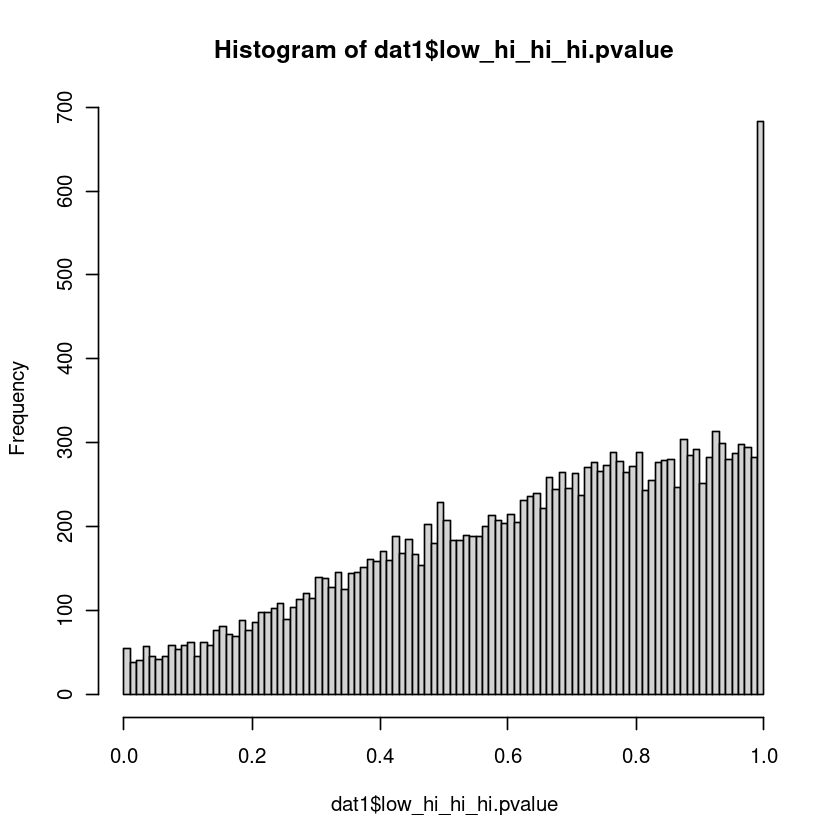

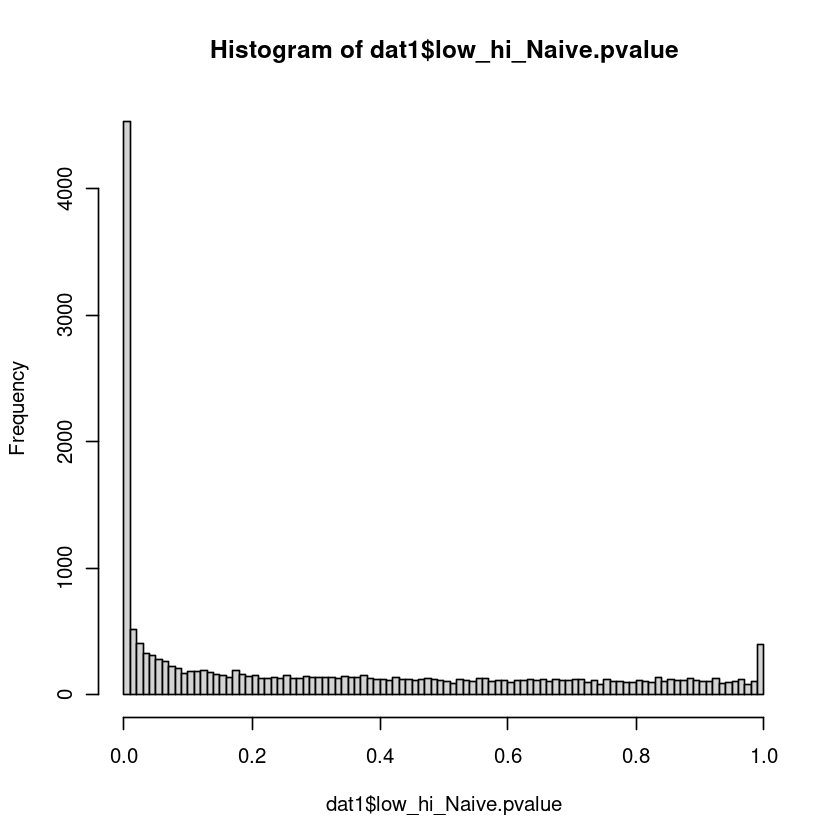

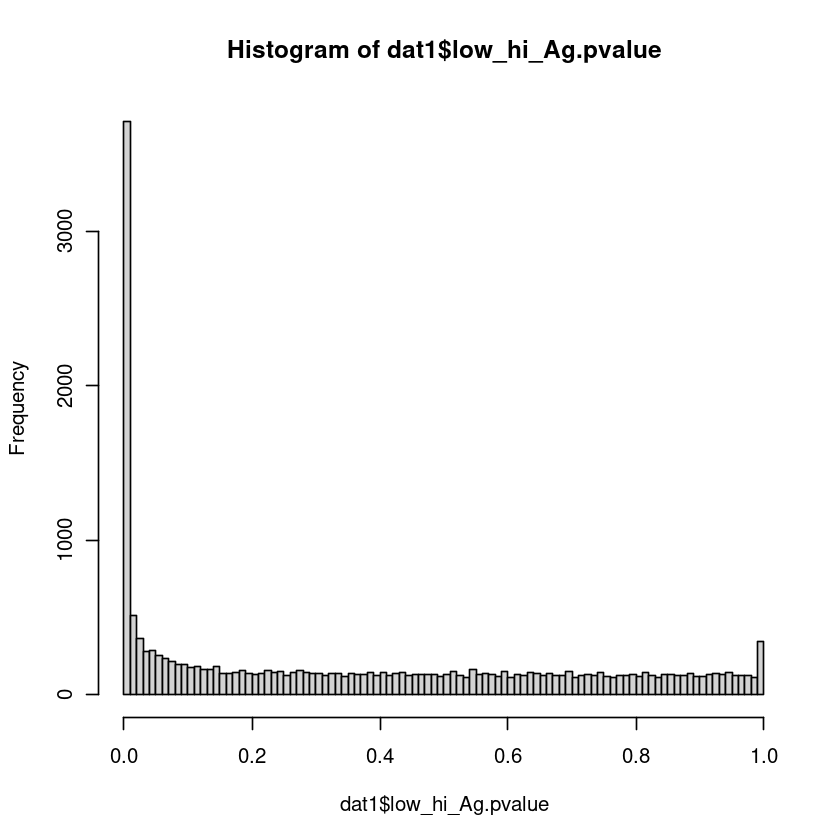

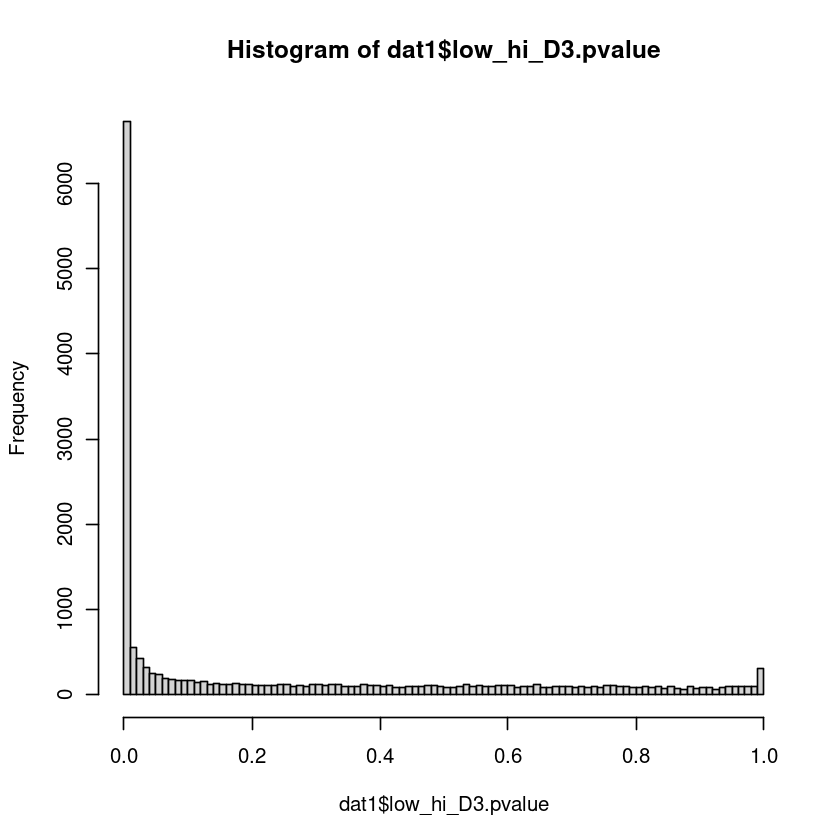

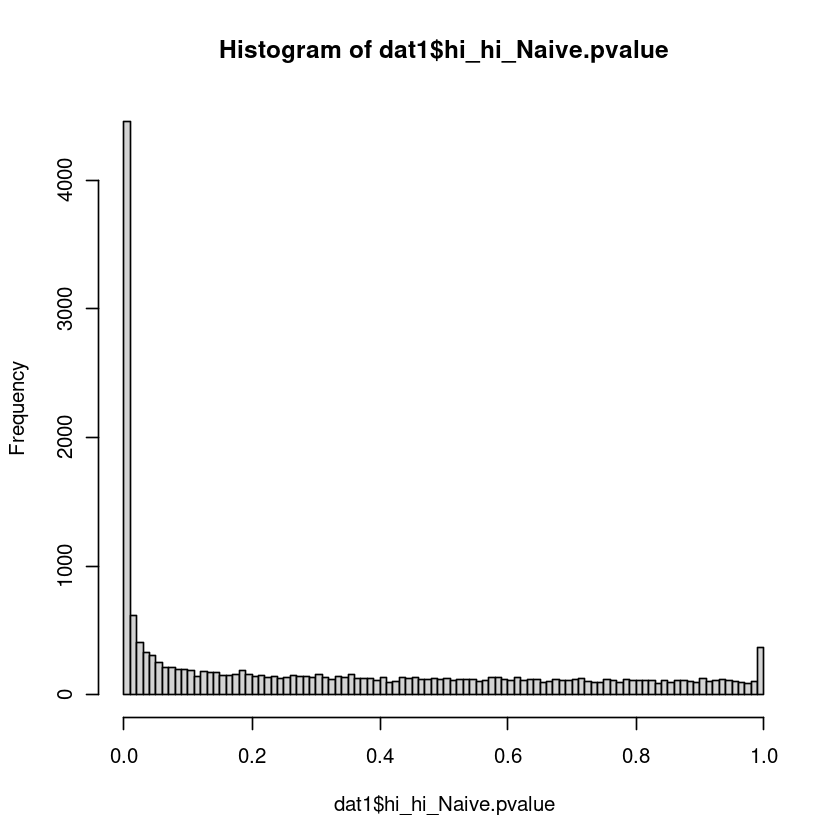

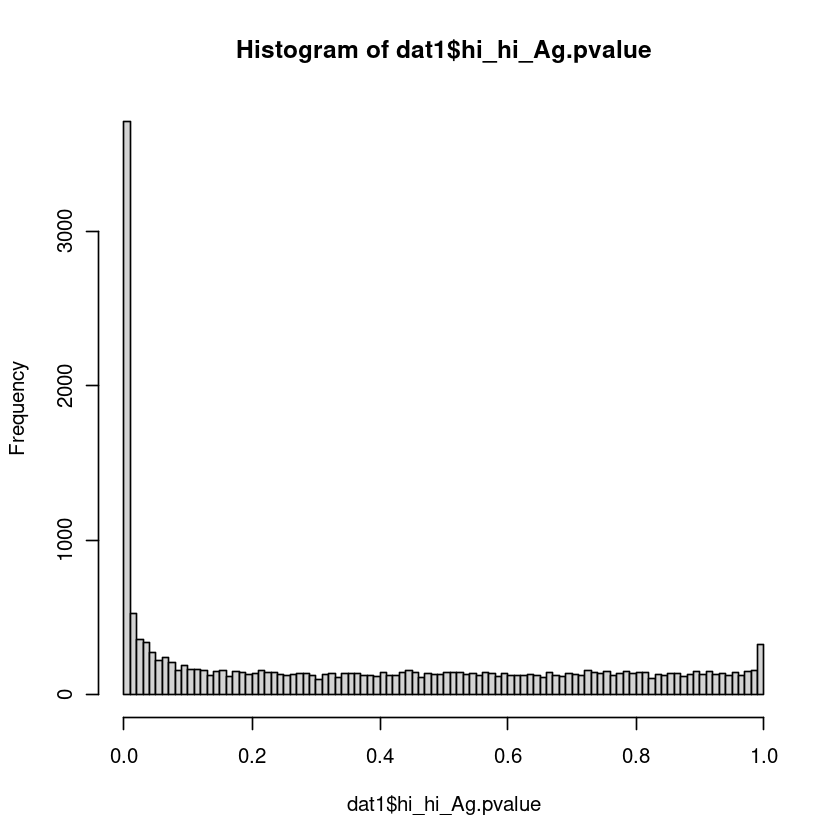

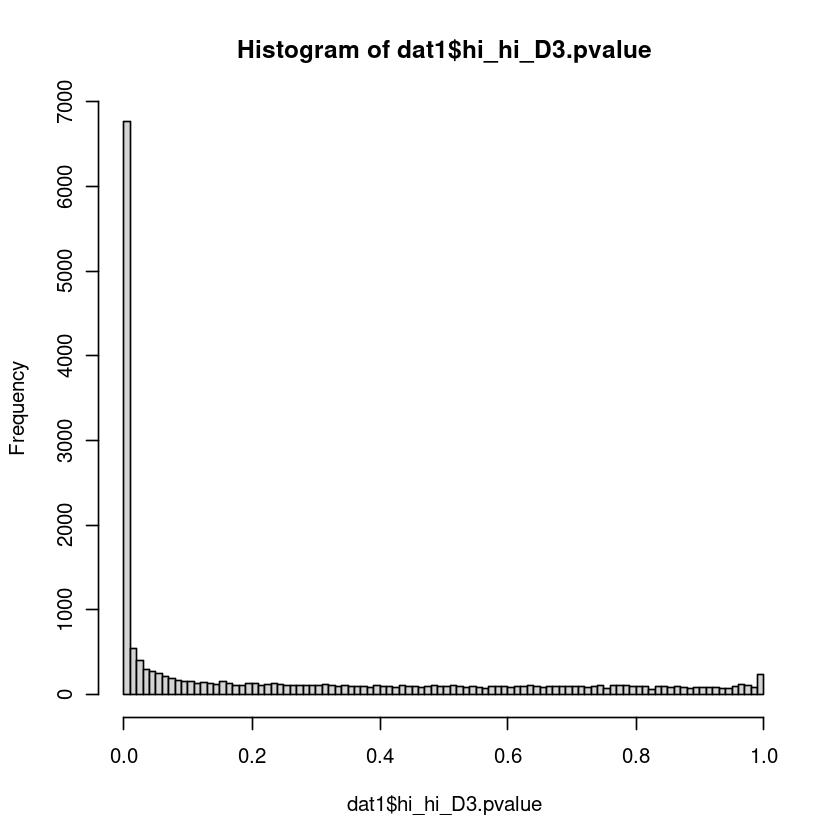

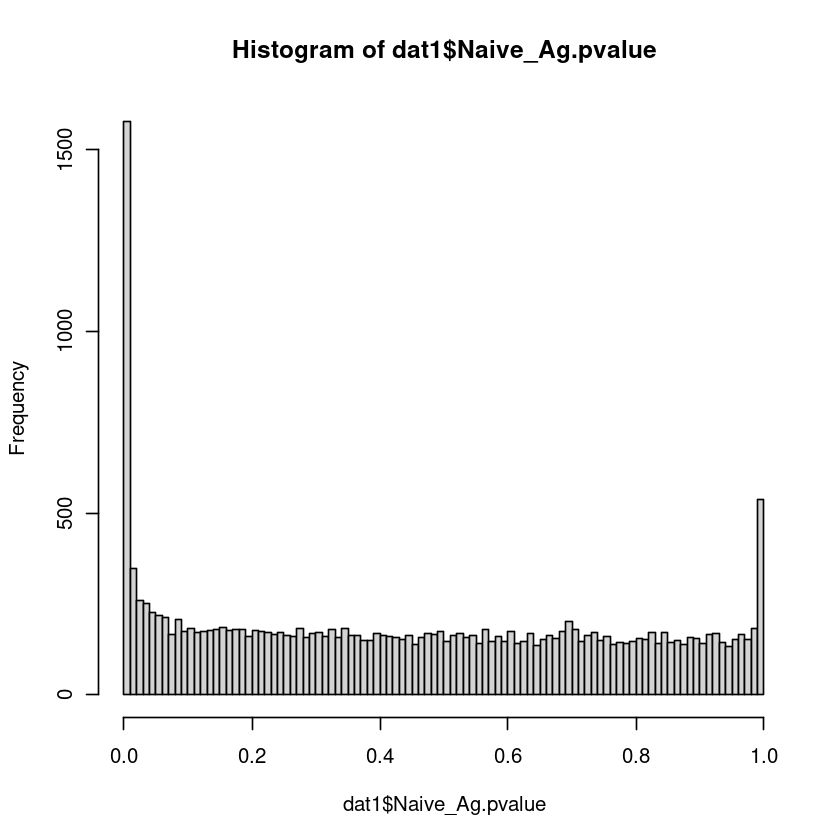

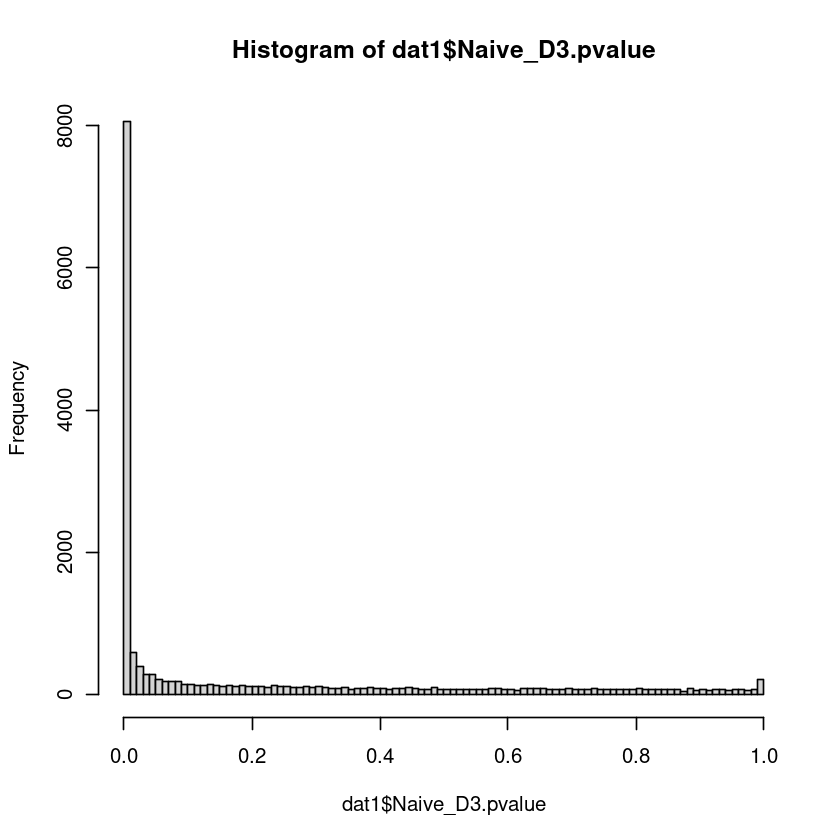

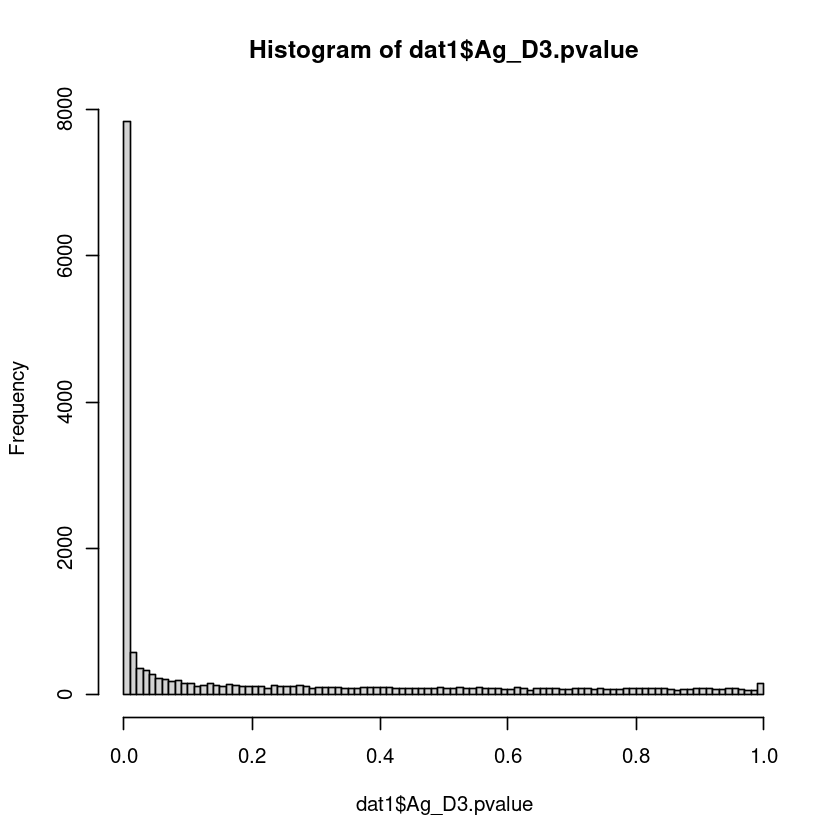

In [11]:
hist(dat1$low_hi_hi_hi.pvalue,breaks = 100)
hist(dat1$low_hi_Naive.pvalue,breaks = 100)
hist(dat1$low_hi_Ag.pvalue,breaks = 100)
hist(dat1$low_hi_D3.pvalue,breaks = 100)
hist(dat1$hi_hi_Naive.pvalue,breaks = 100)
hist(dat1$hi_hi_Ag.pvalue,breaks = 100)
hist(dat1$hi_hi_D3.pvalue,breaks = 100)
hist(dat1$Naive_Ag.pvalue,breaks = 100)
hist(dat1$Naive_D3.pvalue,breaks = 100)
hist(dat1$Ag_D3.pvalue,breaks = 100)

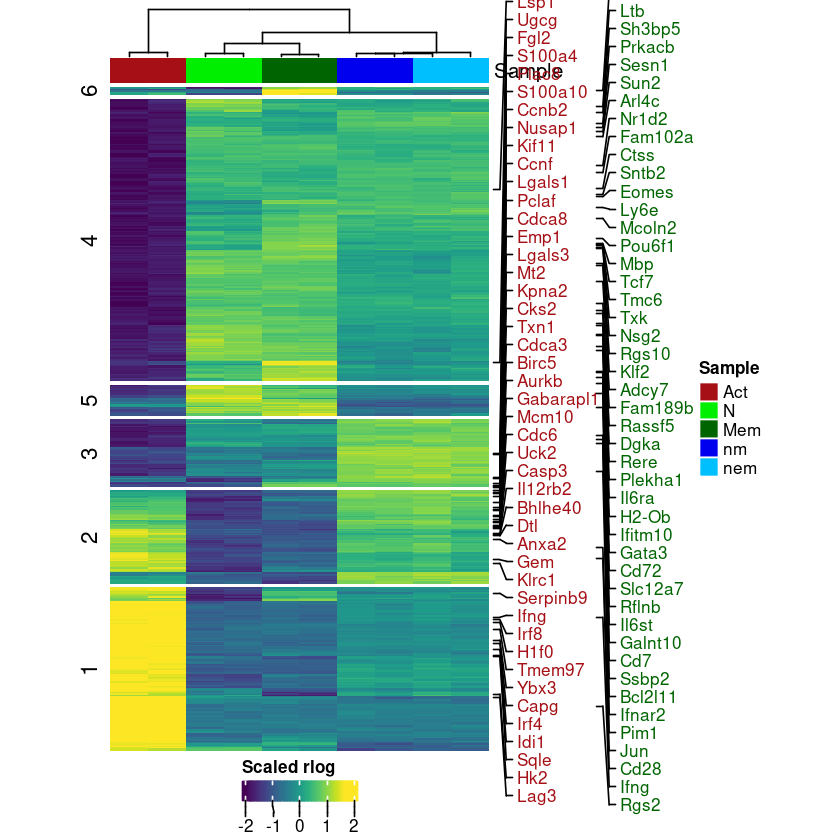

In [12]:
# Variable between LH and HH
dat1_LH_HH <- dat1[dat1$low_hi_hi_hi.padj_pass_filter ==1, ]
dds1_LH_HH <- dds1[dat1$low_hi_hi_hi.padj_pass_filter ==1, ]

# Aggregate variable enh between each D9 sample and each control
select <- unique(c(
which(dat1$low_hi_Naive.padj_pass_filter ==1),
which(dat1$low_hi_Ag.padj_pass_filter ==1),
which(dat1$low_hi_D3.padj_pass_filter ==1),
which(dat1$hi_hi_Naive.padj_pass_filter ==1),
which(dat1$hi_hi_Ag.padj_pass_filter ==1),
which(dat1$hi_hi_D3.padj_pass_filter ==1)))
dat1_D9_c <- dat1[select, ]
dds1_D9_c <- dds1[select, ]

# rlog
# rld_LH_HH <- rlog(dds1_LH_HH)
rld_D9_c <- rlog(dds1_D9_c)

# select data for heatmap
rld_hm <- rld_D9_c
dat1_hm <- dat1_D9_c
dds1_hm <- dds1_D9_c

# select most significant peaks by either p value or fold change
# get minimum of all tested p value
padj_cols <- grep("padj", colnames(dat1_hm))
padj_filt_cols <- grep("padj_pass_filter", colnames(dat1_hm))
padj_cols <- padj_cols[!(padj_cols %in% padj_filt_cols)]
dat1_hm$padj_min <- apply(dat1_hm[ , padj_cols], 1, min)
# take lowest n min adj p value
top_n <- head(order(dat1_hm$padj_min), n=500)
dat1_hm <- dat1_hm[top_n, ]
dds1_hm <- dds1_hm[top_n, ]
rld_hm <- rld_hm[top_n, ]

# heatmap matrix prep
mat <- assay(rld_hm)
colnames(mat)<- sample_id
mat_scale <- t(scale(t(mat)))

# genes to label Goldrath/Kaech eff
g_fig <- EffvMem_UP
genes_to_label_pos_4 <- which(rownames(mat_scale) %in% g_fig )
genes_to_label_4 <- rownames(mat_scale[genes_to_label_pos_4, ])  

# genes to label Goldrath/Kaech mem
g_fig <- EffvMem_DN
genes_to_label_pos_5 <- which(rownames(mat_scale) %in% g_fig )
genes_to_label_5 <- rownames(mat_scale[genes_to_label_pos_5, ])  

# column sample name annotations
labels <- c('Act', 'nm', 'nem', 'Act', 'nm', 'nem', 'Mem', 'N', 'Mem', 'N')
labels <- factor(labels, levels = c('Act','N', 'Mem', 'nm','nem' ))
ann <- data.frame(labels)
colnames(ann) <- c('Sample')
colors_anno = list('Sample' = c('Act' = '#A50F15', 'N' = 'green2', 'Mem' = 'darkgreen', 'nem' = 'deepskyblue1', 'nm' = 'blue2'))
colAnn <- HeatmapAnnotation(df = ann, 
  which = 'col',
  col = colors_anno, 
  annotation_width = unit(c(1, 4), 'cm'),
  gap = unit(1, 'mm'),
  annotation_legend_param = list(Sample = list(direction = "horizontal")))
                           


# annotate rows with genes
ha = rowAnnotation(
                   a4=anno_mark(at= genes_to_label_pos_4, labels = genes_to_label_4, which="row", labels_gp = gpar(col= "#A50F15",fontsize = 10)),
                   a5=anno_mark(at= genes_to_label_pos_5, labels = genes_to_label_5, which="row", labels_gp = gpar(col= "darkgreen",fontsize = 10))
                   ) 

# Complex heatmap

#k-means cluster the peaks
set.seed(123)
split = data.frame(cutree(hclust(dist(mat_scale)), k = 6))
split = split %>% dplyr::rename(clust = 1)
split$clust <- factor(split$clust, levels = c(6,4,5,3,2,1))

ht_list = Heatmap(mat_scale, 
    col = colorRamp2(seq(from=-2, to=2, by = (2--2)/12)[1:12], viridis::viridis(12)),
    name = "Scaled rlog", 
    show_column_names = FALSE, # false when using column annotation instead 
    show_row_names = FALSE, 
    row_names_gp = gpar(fontsize = 4), 
    cluster_columns = TRUE, 
    column_dend_reorder = c(1,8,10,1,8,10,5,3,5,3), # weights for reordering dendrogram 
    cluster_rows = TRUE, 
    show_column_dend = TRUE,
    show_row_dend = FALSE,
    width = unit(8, "cm"),
    clustering_method_rows = "complete",
    
    # split by dendrogram
#     cluster_row_slices = TRUE, 
    cluster_row_slices = FALSE, # manual ordering          
    row_split = split,   
    
    # annotation
    right_annotation = ha,
    top_annotation=colAnn,
                  
    # remove row cluster annotations
#     row_title = NULL,
                  
    heatmap_legend_param = list(direction = "horizontal")
   
)



ht_list = draw(ht_list, annotation_legend_side="right", heatmap_legend_side = "bottom")




In [13]:
pdf("RNA_hm_deseq_clustering-complete_adj-p_n500_dendro-split-6_cols-clustered_reorder_GRanno_2022-09v4_viridis_legend2_cluster_titles.pdf", width=8, height=12)
draw(ht_list)
dev.off()

png 
  2

Output gene lists for each row cluster

In [440]:
clusterlist = row_order(ht_list)

# output gene lists
clu_df <- lapply(names(clusterlist), function(i){
  out <- data.frame(GeneID = rownames(mat_scale[clusterlist[[i]],]),
                                             Cluster = paste0("row_cluster_", i),
                                             stringsAsFactors = FALSE)
     return(out)
   }) %>%  
     do.call(rbind, .)

# output each cluster list to txt file 
write(clu_df[which(clu_df$Cluster == 'row_cluster_1'), ]$GeneID, file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c1.txt"))
write(clu_df[which(clu_df$Cluster == 'row_cluster_2'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c2.txt"))
write(clu_df[which(clu_df$Cluster == 'row_cluster_3'), ]$GeneID, file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c3.txt"))
write(clu_df[which(clu_df$Cluster == 'row_cluster_4'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c4.txt"))
write(clu_df[which(clu_df$Cluster == 'row_cluster_5'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c5.txt"))
write(clu_df[which(clu_df$Cluster == 'row_cluster_6'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c6.txt"))


# additionally, subset matrix into different heatmap clusters and save these as csv
hm_df <- data.frame(mat_scale)
colnames(hm_df) <- c('M1_Act', 'M1_Mem_nm', 'M1_Mem_nem', 'M3_Act', 'M3_Mem_nm', 'M3_Mem_nem', 'M4_Mem', 'M4_N','M5_Mem', 'M5_N')

write.csv(hm_df[clusterlist[[1]],], file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_matrix_c6.csv"))
write.csv(hm_df[clusterlist[[2]],], file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_matrix_c4.csv"))
write.csv(hm_df[clusterlist[[3]],], file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_matrix_c5.csv"))
write.csv(hm_df[clusterlist[[4]],], file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_matrix_c3.csv"))
write.csv(hm_df[clusterlist[[5]],], file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_matrix_c2.csv"))
write.csv(hm_df[clusterlist[[6]],], file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_matrix_c1.csv"))

# or write all to same excel file with different sheets
library(openxlsx)
sheet_names <- names <- list('row_cluster_6' = hm_df[clusterlist[[1]],],
                             'row_cluster_4' = hm_df[clusterlist[[2]],],
                             'row_cluster_5' = hm_df[clusterlist[[3]],],
                             'row_cluster_3' = hm_df[clusterlist[[4]],],
                             'row_cluster_2' = hm_df[clusterlist[[5]],],
                             'row_cluster_1' = hm_df[clusterlist[[6]],])
openxlsx::write.xlsx(sheet_names, rowNames = TRUE, file = file.path('heatmap_cluster_genes', 'bulk_RNA_hm_6clust_matrix_row_clusters.xlsx'))
          

Output gene lists for each row cluster, but now only for eff and mem annotation genes, separately

In [485]:
# First subset to only include effector genes
clu_df_eff <- clu_df %>% filter(GeneID %in% EffvMem_UP)

# output each cluster list to txt file 
write(clu_df_eff[which(clu_df_eff$Cluster == 'row_cluster_1'), ]$GeneID, file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c1_eff.txt"), ncolumns = length(which(clu_df_eff$Cluster == 'row_cluster_1')), sep = ", ")
write(clu_df_eff[which(clu_df_eff$Cluster == 'row_cluster_2'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c2_eff.txt"), ncolumns = length(which(clu_df_eff$Cluster == 'row_cluster_2')), sep = ", ")
write(clu_df_eff[which(clu_df_eff$Cluster == 'row_cluster_3'), ]$GeneID, file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c3_eff.txt"), ncolumns = length(which(clu_df_eff$Cluster == 'row_cluster_3')), sep = ", ")
write(clu_df_eff[which(clu_df_eff$Cluster == 'row_cluster_4'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c4_eff.txt"), ncolumns = length(which(clu_df_eff$Cluster == 'row_cluster_4')), sep = ", ")
# write(clu_df_eff[which(clu_df_eff$Cluster == 'row_cluster_5'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c5_eff.txt"), ncolumns = length(which(clu_df_eff$Cluster == 'row_cluster_5')), sep = ", ")
# write(clu_df_eff[which(clu_df_eff$Cluster == 'row_cluster_6'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c6_eff.txt"), ncolumns = length(which(clu_df_eff$Cluster == 'row_cluster_6')), sep = ", ")

# First subset to only include mem genes
clu_df_mem <- clu_df %>% filter(GeneID %in% EffvMem_DN)

# output each cluster list to txt file 
write(clu_df_mem[which(clu_df_mem$Cluster == 'row_cluster_1'), ]$GeneID, file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c1_mem.txt"), ncolumns = length(which(clu_df_mem$Cluster == 'row_cluster_1')), sep = ", ")
write(clu_df_mem[which(clu_df_mem$Cluster == 'row_cluster_2'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c2_mem.txt"), ncolumns = length(which(clu_df_mem$Cluster == 'row_cluster_2')), sep = ", ")
write(clu_df_mem[which(clu_df_mem$Cluster == 'row_cluster_3'), ]$GeneID, file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c3_mem.txt"), ncolumns = length(which(clu_df_mem$Cluster == 'row_cluster_3')), sep = ", ")
write(clu_df_mem[which(clu_df_mem$Cluster == 'row_cluster_4'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c4_mem.txt"), ncolumns = length(which(clu_df_mem$Cluster == 'row_cluster_4')), sep = ", ")
write(clu_df_mem[which(clu_df_mem$Cluster == 'row_cluster_5'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c5_mem.txt"), ncolumns = length(which(clu_df_mem$Cluster == 'row_cluster_5')), sep = ", ")
write(clu_df_mem[which(clu_df_mem$Cluster == 'row_cluster_6'), ]$GeneID,file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c6_mem.txt"), ncolumns = length(which(clu_df_mem$Cluster == 'row_cluster_6')), sep = ", ")


Gene ontology analysis using enrichR

In [388]:
c1_gene_list <- read.table(file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c1.txt"))$V1
c1_gene_list

[1] "Cd28"      "Gem"       "Tbkbp1"    "Adora2a"   "Klrc1"     "Tbx21"    
  [7] "Chst11"    "Slamf7"    "Plek"      "Il2rb"     "Cd44"      "Pgam1"    
 [13] "Morf4l2"   "Mif"       "Eif3c"     "Gars"      "Prep"      "Gapdh"    
 [19] "Plk2"      "Uqcrfs1"   "Ssr2"      "Eif5a"     "Crem"      "Pgk1"     
 [25] "Hsp90b1"   "Rnh1"      "P4hb"      "Aldoa"     "Bsg"       "Serpinb9" 
 [31] "Eno1"      "Pkm"       "Pdia6"     "Psat1"     "Tpi1"      "Ldha"     
 [37] "Egln3"     "Phgdh"     "Manf"      "Rbpj"      "Tcp1"      "Furin"    
 [43] "Eprs"      "Eif4ebp1"  "Hif1a"     "Ern1"      "Hspd1"     "Eif2s2"   
 [49] "Gm10053"   "Ifng"      "Ccl3"      "Irf8"      "Nfil3"     "H1f0"     
 [55] "Etv6"      "Hmgcr"     "Prdx2"     "Mpp6"      "Mthfd2"    "Tmem97"   
 [61] "Odc1"      "Fads2"     "Fabp5"     "Tkt"       "Ahcy"      "Tnfrsf18" 
 [67] "Scd2"      "Vdac1"     "Ybx3"      "Gcat"      "Rilpl2"    "Capg"     
 [73] "Ccdc50"    "Srgn"      "Asns"      "Sdf2l1"    "Irf4"      "Repin1"   
 [79] "Hprt"      "Fdps"      "Ggta1"     "Idi1"      "Sqle"      "Dhcr24"   
 [85] "Ldlr"      "Pfkl"      "Junb"      "Mpzl3"     "Nfkb2"     "Traf4"    
 [91] "Tubb6"     "Atp2a2"    "Trim66"    "Sytl3"     "Hyou1"     "Hax1"     
 [97] "Hspa5"     "Tnfrsf9"   "Nkain1"    "Slc7a5"    "Marcksl1"  "Il1rl1"   
[103] "Hspa9"     "Tnfrsf4"   "Inhba"     "Ncs1"      "Dclk1"     "Ccl9"     
[109] "Sdcbp2"    "Galk1"     "Fam162a"   "Adarb1"    "Stat5a"    "Hk2"      
[115] "Rrbp1"     "Sema7a"    "Lag3"      "Zbtb32"    "Dusp4"     "Fosl2"    
[121] "Serpinb6b" "Gm2808"    "Prf1"      "Rgs2"      "Tagap"     "Cnn3"     
[127] "Nab2"

In [406]:
dbs <- listEnrichrDbs()
dbs

geneCoverage,genesPerTerm,libraryName,link,numTerms,appyter,categoryId
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
13362,275,Genome_Browser_PWMs,http://hgdownload.cse.ucsc.edu/goldenPath/hg18/database/,615,ea115789fcbf12797fd692cec6df0ab4dbc79c6a,1
27884,1284,TRANSFAC_and_JASPAR_PWMs,http://jaspar.genereg.net/html/DOWNLOAD/,326,7d42eb43a64a4e3b20d721fc7148f685b53b6b30,1
6002,77,Transcription_Factor_PPIs,,290,849f222220618e2599d925b6b51868cf1dab3763,1
47172,1370,ChEA_2013,http://amp.pharm.mssm.edu/lib/cheadownload.jsp,353,7ebe772afb55b63b41b79dd8d06ea0fdd9fa2630,7
47107,509,Drug_Perturbations_from_GEO_2014,http://www.ncbi.nlm.nih.gov/geo/,701,ad270a6876534b7cb063e004289dcd4d3164f342,7
21493,3713,ENCODE_TF_ChIP-seq_2014,http://genome.ucsc.edu/ENCODE/downloads.html,498,497787ebc418d308045efb63b8586f10c526af51,7
1295,18,BioCarta_2013,https://cgap.nci.nih.gov/Pathways/BioCarta_Pathways,249,4a293326037a5229aedb1ad7b2867283573d8bcd,7
3185,73,Reactome_2013,http://www.reactome.org/download/index.html,78,b343994a1b68483b0122b08650201c9b313d5c66,7
2854,34,WikiPathways_2013,http://www.wikipathways.org/index.php/Download_Pathways,199,5c307674c8b97e098f8399c92f451c0ff21cbf68,7


In [422]:
dbs <- listEnrichrDbs()
# choose databases to use
dbs_sel <- c("GO_Biological_Process_2018")

c1_gene_list <- read.table(file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c1.txt"))$V1
c2_gene_list <- read.table(file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c2.txt"))$V1
c3_gene_list <- read.table(file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c3.txt"))$V1
c4_gene_list <- read.table(file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c4.txt"))$V1
c5_gene_list <- read.table(file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c5.txt"))$V1
c6_gene_list <- read.table(file.path("heatmap_cluster_genes", "bulk_RNA_hm_6clust_genelist_c6.txt"))$V1

# run enrichr for each gene list
enr_c1 <- enrichr(c1_gene_list, dbs_sel)[[1]]
enr_c2 <- enrichr(c2_gene_list, dbs_sel)[[1]]
enr_c3 <- enrichr(c3_gene_list, dbs_sel)[[1]]
enr_c4 <- enrichr(c4_gene_list, dbs_sel)[[1]]
enr_c5 <- enrichr(c5_gene_list, dbs_sel)[[1]]
enr_c6 <- enrichr(c6_gene_list, dbs_sel)[[1]]


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.


In [431]:
process_topn <- 10

# take top 10 by adjusted p value of each 
enr_c1_top <- enr_c1 %>% dplyr::arrange(Adjusted.P.value) %>% top_n(process_topn, Adjusted.P.value)
enr_c2_top <- enr_c2 %>% dplyr::arrange(Adjusted.P.value) %>% top_n(process_topn, Adjusted.P.value)
enr_c3_top <- enr_c3 %>% dplyr::arrange(Adjusted.P.value) %>% top_n(process_topn, Adjusted.P.value)
enr_c4_top <- enr_c4 %>% dplyr::arrange(Adjusted.P.value) %>% top_n(process_topn, Adjusted.P.value)
enr_c5_top <- enr_c5 %>% dplyr::arrange(Adjusted.P.value) %>% top_n(process_topn, Adjusted.P.value)
enr_c6_top <- enr_c6 %>% dplyr::arrange(Adjusted.P.value) %>% top_n(process_topn, Adjusted.P.value)

enr_c1_top
enr_c2_top
enr_c3_top
enr_c4_top
enr_c5_top
enr_c6_top

Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
cellular response to oxygen-containing compound (GO:1901701),1/275,0.8286352,0.8353178,0,0,0.5676920,0.10671204,HSP90B1
mRNA processing (GO:0006397),1/284,0.8383152,0.8443192,0,0,0.5493858,0.09689033,ERN1
DNA repair (GO:0006281),1/289,0.8434564,0.8479790,0,0,0.5397101,0.09188406,IRF4
cilium assembly (GO:0060271),1/289,0.8434564,0.8479790,0,0,0.5397101,0.09188406,RILPL2
protein transport (GO:0015031),1/327,0.8775778,0.8814955,0,0,0.4758740,0.06214425,HSP90B1
cellular response to DNA damage stimulus (GO:0006974),1/330,0.8799335,0.8830733,0,0,0.4714623,0.06030426,IRF4
ubiquitin-dependent protein catabolic process (GO:0006511),1/342,0.8889150,0.8912918,0,0,0.4545920,0.05352988,TBX21
organelle assembly (GO:0070925),1/377,0.9114778,0.9131011,0,0,0.4115375,0.03814458,RILPL2
protein modification by small protein conjugation (GO:0032446),1/399,0.9232669,0.9240883,0,0,0.3883505,0.03100470,HIF1A


Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
regulation of nucleic acid-templated transcription (GO:1903506),2/608,0.6477072,0.6556275,0,0,0.9109854,0.3956561,BHLHE40;E2F1
DNA repair (GO:0006281),1/289,0.6500153,0.6570711,0,0,0.9604851,0.4137379,NABP1
regulation of cellular macromolecule biosynthetic process (GO:2000112),2/632,0.6686994,0.6750421,0,0,0.8751927,0.3521956,BHLHE40;E2F1
"transcription, DNA-templated (GO:0006351)",1/357,0.7272320,0.7331364,0,0,0.7743314,0.2466321,E2F1
regulation of gene expression (GO:0010468),3/1038,0.7289372,0.7338624,0,0,0.7936568,0.2509286,CDK6;BHLHE40;E2F1
organelle assembly (GO:0070925),1/377,0.7465559,0.7505859,0,0,0.7323944,0.2140677,GABARAPL1
transmembrane transport (GO:0055085),1/379,0.7484124,0.7514383,0,0,0.7284447,0.2111041,ATP10A
gene expression (GO:0010467),1/412,0.7771775,0.7790422,0,0,0.6688256,0.1686019,E2F1
positive regulation of protein phosphorylation (GO:0001934),1/413,0.7779965,0.7790422,0,0,0.6671681,0.1674813,FAM129A


Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
protein phosphorylation (GO:0006468),1/471,0.7108613,0.7254680,0,0,0.8125991,0.27732218,CDK19
cellular protein metabolic process (GO:0044267),1/485,0.7214586,0.7336904,0,0,0.7885270,0.25743852,B2M
negative regulation of apoptotic process (GO:0043066),1/486,0.7222008,0.7336904,0,0,0.7868607,0.25608545,F2R
positive regulation of nucleic acid-templated transcription (GO:1903508),1/503,0.7345255,0.7445190,0,0,0.7595500,0.23434443,F2R
regulation of transcription from RNA polymerase II promoter (GO:0006357),3/1479,0.7498804,0.7583632,0,0,0.7662187,0.22054954,PPP3CA;NLRC5;SSBP2
regulation of gene expression (GO:0010468),2/1038,0.7596884,0.7665479,0,0,0.7301931,0.20069128,MBNL1;SSBP2
regulation of nucleic acid-templated transcription (GO:1903506),1/608,0.7995927,0.8049953,0,0,0.6247698,0.13973155,SSBP2
regulation of cellular macromolecule biosynthetic process (GO:2000112),1/632,0.8121073,0.8157572,0,0,0.6002610,0.12492804,SSBP2
positive regulation of gene expression (GO:0010628),1/772,0.8712164,0.8731698,0,0,0.4877038,0.06723720,F2R


Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
cellular protein metabolic process (GO:0044267),3/485,0.9048992,0.9126053,0,0,0.5535117,0.055313384,GOLM1;STK38;SORL1
transcription from RNA polymerase II promoter (GO:0006366),3/486,0.9056421,0.9126053,0,0,0.5523371,0.054742727,IRF7;NR1D2;GATA3
"transcription, DNA-templated (GO:0006351)",2/357,0.9061835,0.9126053,0,0,0.5020028,0.049454026,IRF7;GATA3
post-translational protein modification (GO:0043687),2/358,0.9070221,0.9127311,0,0,0.5005670,0.048849578,FBXW4;GOLM1
mitotic cell cycle phase transition (GO:0044772),1/222,0.9153522,0.9203896,0,0,0.4041199,0.035742922,LATS2
proteasomal protein catabolic process (GO:0010498),1/238,0.9292281,0.9336078,0,0,0.3765293,0.027637645,ZNRF2
negative regulation of programmed cell death (GO:0043069),2/409,0.9415857,0.9452811,0,0,0.4366927,0.026284512,CLN3;EVI2B
nervous system development (GO:0007399),2/456,0.9623413,0.9653604,0,0,0.3905347,0.014991120,MYLIP;MBP
DNA metabolic process (GO:0006259),1/315,0.9701607,0.9724417,0,0,0.2830759,0.008575371,AXIN2


Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
neutrophil degranulation (GO:0043312),1/480,0.4282435,0.4484907,0,0,1.8502562,1.5691342,HSPA1B
neutrophil activation involved in immune response (GO:0002283),1/484,0.4309337,0.4484907,0,0,1.8345567,1.5443316,HSPA1B
transcription from RNA polymerase II promoter (GO:0006366),1/486,0.4322743,0.4484907,0,0,1.8268041,1.5321314,DTX1
neutrophil mediated immunity (GO:0002446),1/488,0.4336118,0.4484907,0,0,1.8191152,1.5200627,HSPA1B
protein ubiquitination (GO:0016567),1/507,0.4461690,0.4592276,0,0,1.7491017,1.4116258,BTBD11
positive regulation of cellular process (GO:0048522),1/520,0.4546068,0.4656409,0,0,1.7041513,1.3434208,IL6ST
negative regulation of cellular process (GO:0048523),1/535,0.4641899,0.4731598,0,0,1.6550051,1.2701528,HSPA1B
negative regulation of gene expression (GO:0010629),1/619,0.5149491,0.5223763,0,0,1.4238747,0.9450074,HSPA1B
positive regulation of gene expression (GO:0010628),1/772,0.5958200,0.6015217,0,0,1.1322957,0.5863216,HSPA1B


Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
negative regulation of nucleic acid-templated transcription (GO:1903507),1/445,0.1263053,0.2230910,0,0,8.806306,18.220718,MYB
nervous system development (GO:0007399),1/456,0.1292503,0.2230910,0,0,8.588571,17.572254,ITM2A
positive regulation of nucleic acid-templated transcription (GO:1903508),1/503,0.1417406,0.2230910,0,0,7.765737,15.172359,MYB
negative regulation of cellular macromolecule biosynthetic process (GO:2000113),1/513,0.1443788,0.2230910,0,0,7.610156,14.728049,MYB
negative regulation of transcription from RNA polymerase II promoter (GO:0000122),1/566,0.1582485,0.2230910,0,0,6.877522,12.679324,MYB
regulation of nucleic acid-templated transcription (GO:1903506),1/608,0.1691060,0.2230910,0,0,6.387809,11.352603,MYB
negative regulation of gene expression (GO:0010629),1/619,0.1719303,0.2230910,0,0,6.270550,11.040347,MYB
regulation of cellular macromolecule biosynthetic process (GO:2000112),1/632,0.1752577,0.2230910,0,0,6.137242,10.687994,MYB
cytokine-mediated signaling pathway (GO:0019221),1/634,0.1757686,0.2230910,0,0,6.117220,10.635316,IL18RAP


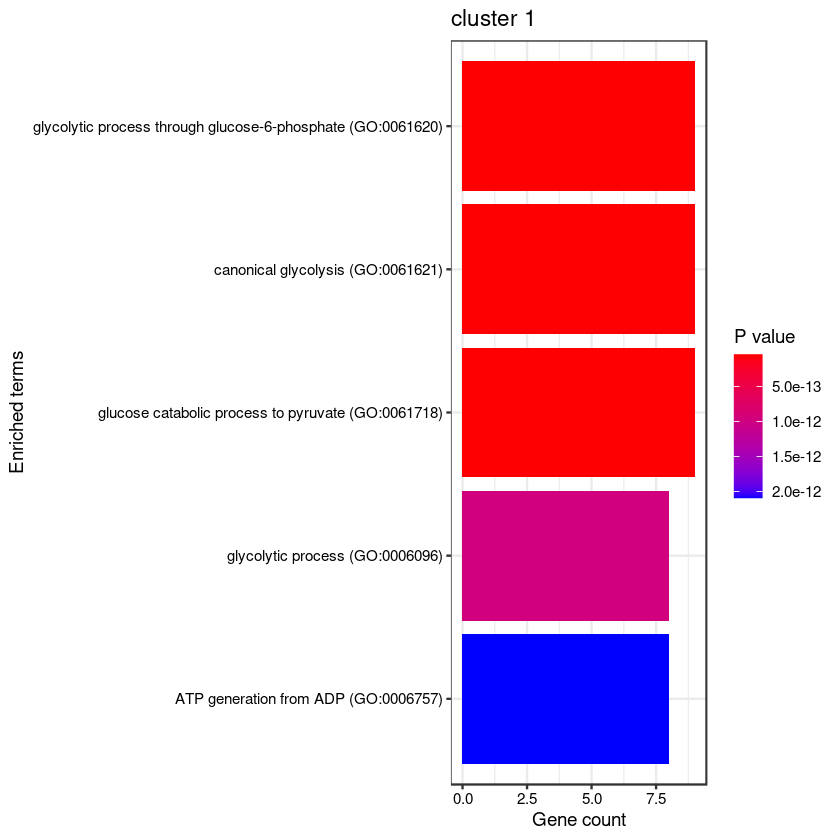

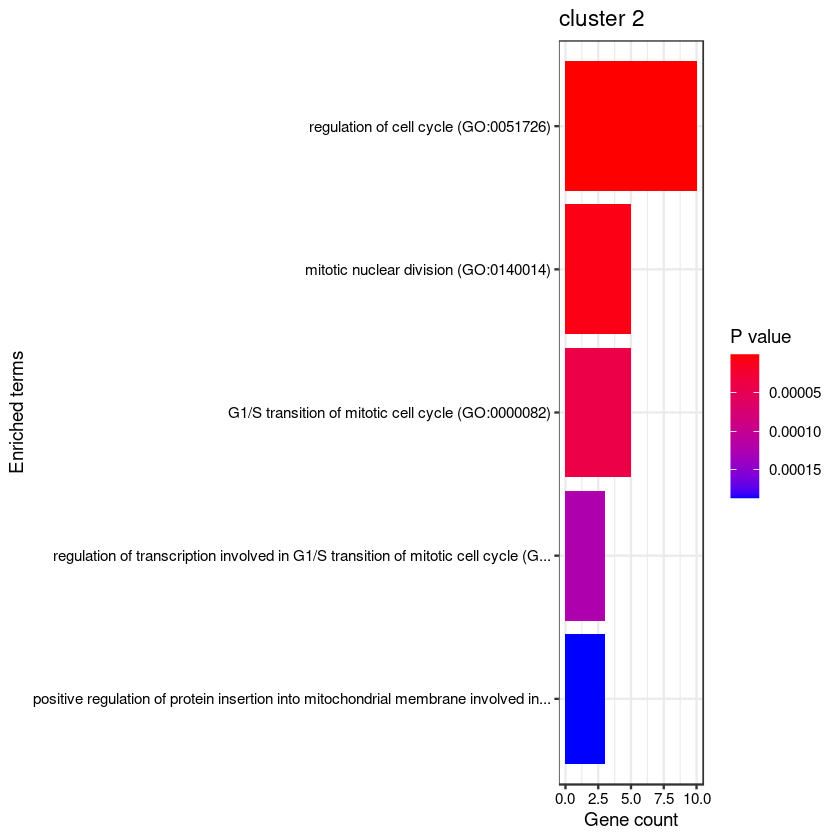

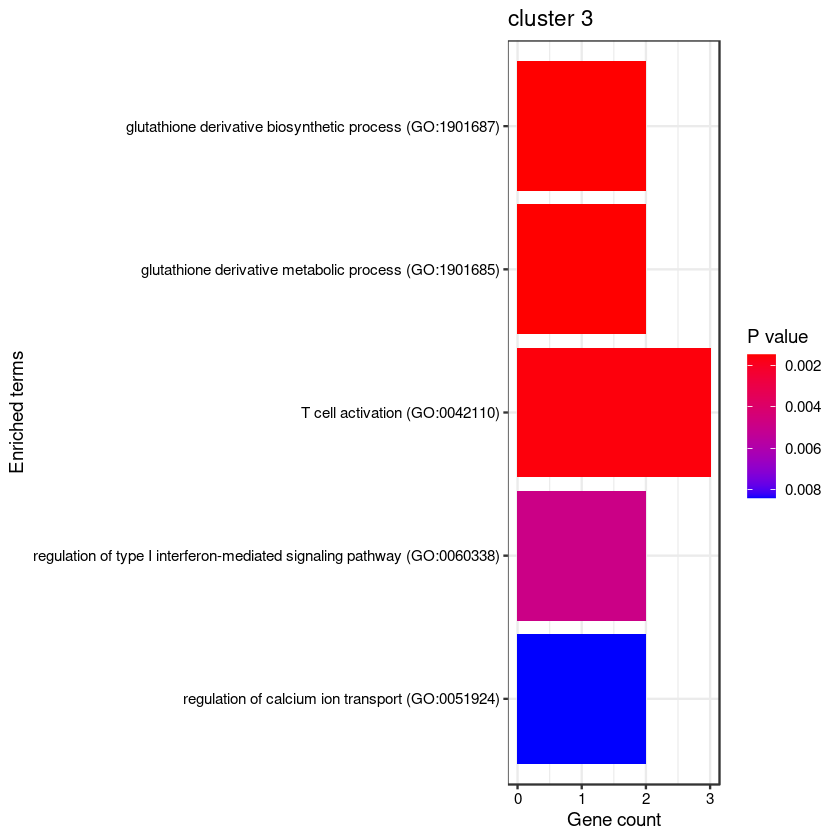

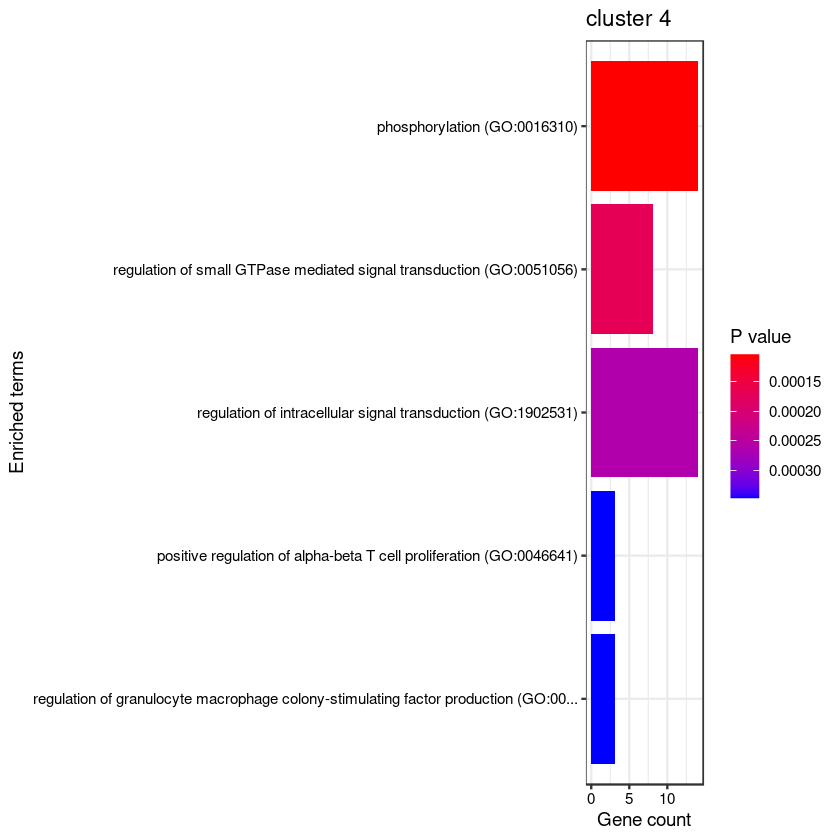

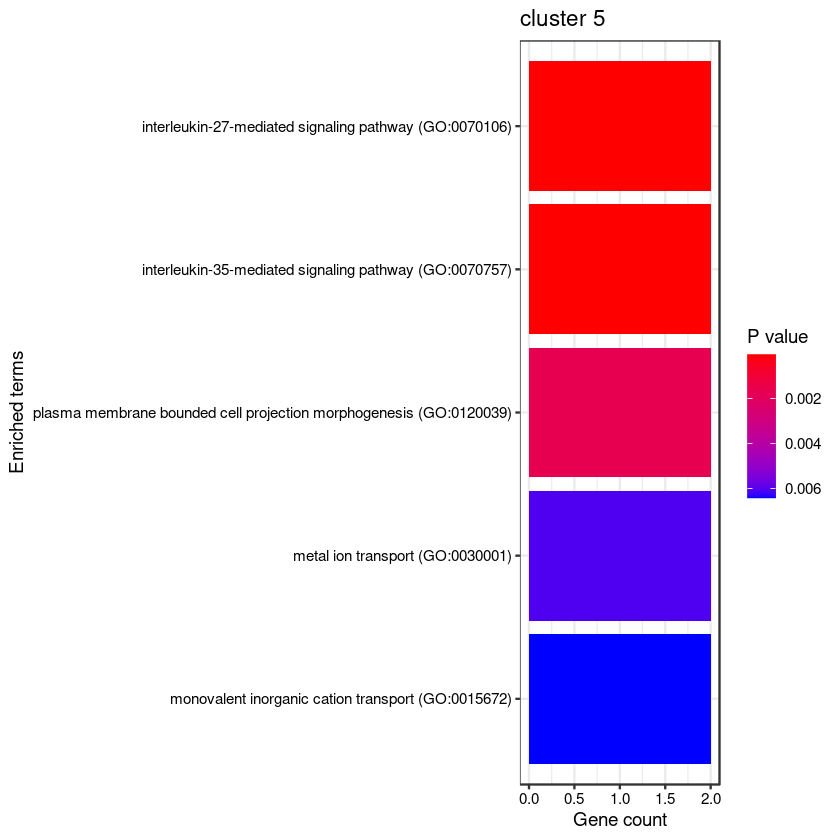

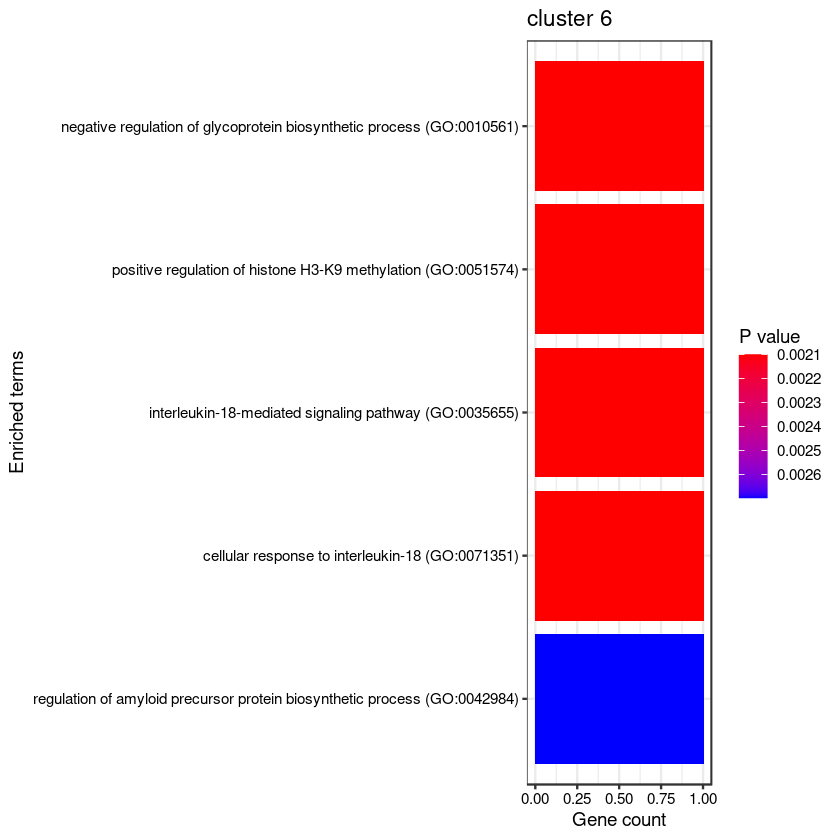

In [414]:


plotEnrich(enr_c1$GO_Biological_Process_2018, showTerms = process_topn, numChar = 80, y = "Count", orderBy = "Adjusted.P.value") + ggtitle('cluster 1')
plotEnrich(enr_c2$GO_Biological_Process_2018, showTerms = process_topn, numChar = 80, y = "Count", orderBy = "Adjusted.P.value") + ggtitle('cluster 2')
plotEnrich(enr_c3$GO_Biological_Process_2018, showTerms = process_topn, numChar = 80, y = "Count", orderBy = "Adjusted.P.value") + ggtitle('cluster 3')
plotEnrich(enr_c4$GO_Biological_Process_2018, showTerms = process_topn, numChar = 80, y = "Count", orderBy = "Adjusted.P.value") + ggtitle('cluster 4')
plotEnrich(enr_c5$GO_Biological_Process_2018, showTerms = process_topn, numChar = 80, y = "Count", orderBy = "Adjusted.P.value") + ggtitle('cluster 5')
plotEnrich(enr_c6$GO_Biological_Process_2018, showTerms = process_topn, numChar = 80, y = "Count", orderBy = "Adjusted.P.value") + ggtitle('cluster 6')

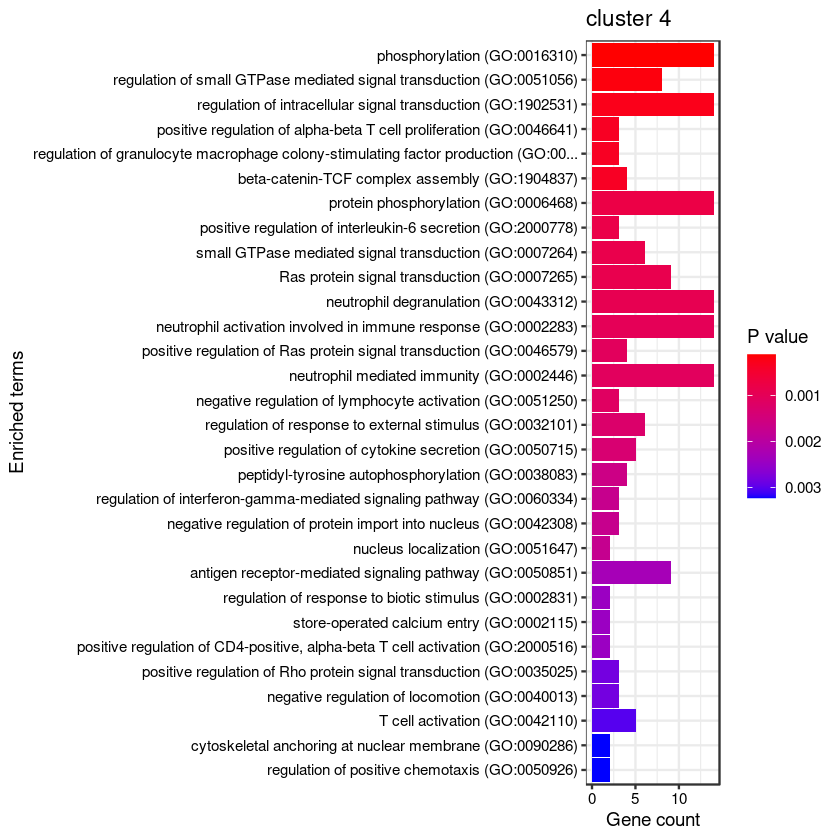

In [411]:
plotEnrich(enr_c4$GO_Biological_Process_2018, showTerms = 30, numChar = 80, y = "Count", orderBy = "Adjusted.P.value") + ggtitle('cluster 4')




PCA 

In [462]:
# refactor 
rld_hm$cond <- factor(rld_hm$cond, levels = c('D3', 'Naive', 'Ag', 'hi_hi', 'low_hi'))


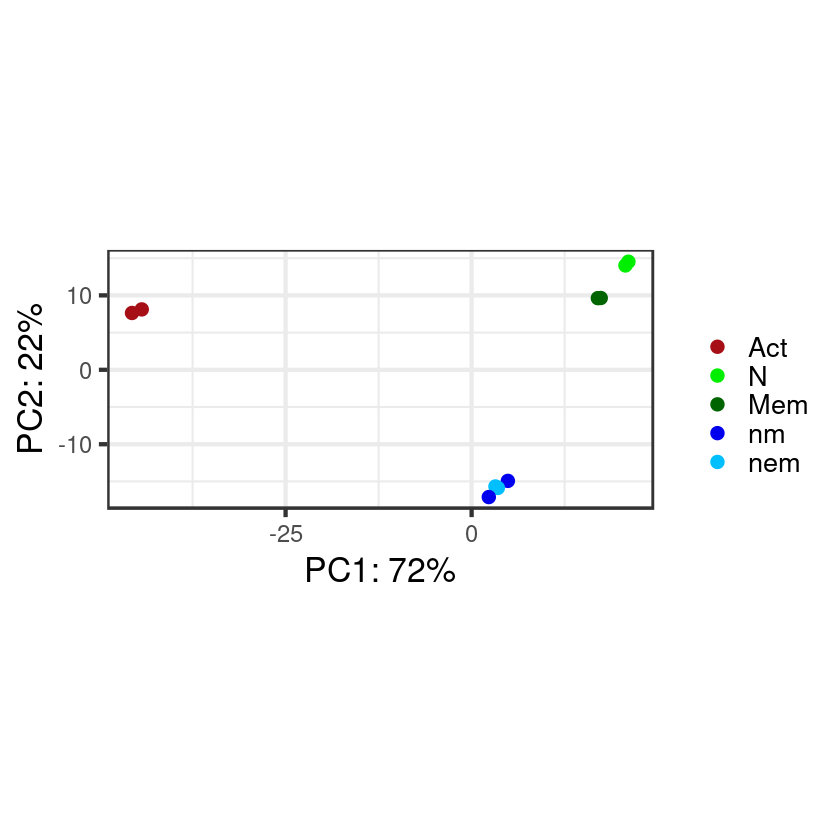

In [489]:
# colors 
cols <-  c("#A50F15", "green2", "darkgreen", "blue2", "deepskyblue1")

# plot theme
pca_theme <- theme( text=element_text(size=18))


# PCA using top 500 DEG with padj <.05 between controls and D9
pcaData <- plotPCA(rld_hm, intgroup=c("cond"), returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
g <- ggplot(pcaData, aes(PC1, PC2, color=cond)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"%")) +
  ylab(paste0("PC2: ",percentVar[2],"%")) + 
  coord_fixed() + scale_color_manual("",labels=c('Act', 'N', 'Mem', 'nm', 'nem'), values = cols) +
theme_bw(base_size=20) + theme(axis.text=element_text(size=14))

g
save_plot(g, file = "RNA_pca_D9_c_0LL.pdf")




Correlation map as alternative to PCA

In [444]:
mat_dist <- rld_hm
mat_dist$cond

[1] D3     hi_hi  low_hi D3     hi_hi  low_hi Ag     Naive  Ag     Naive 
Levels: D3 Naive Ag hi_hi low_hi

png 
  2

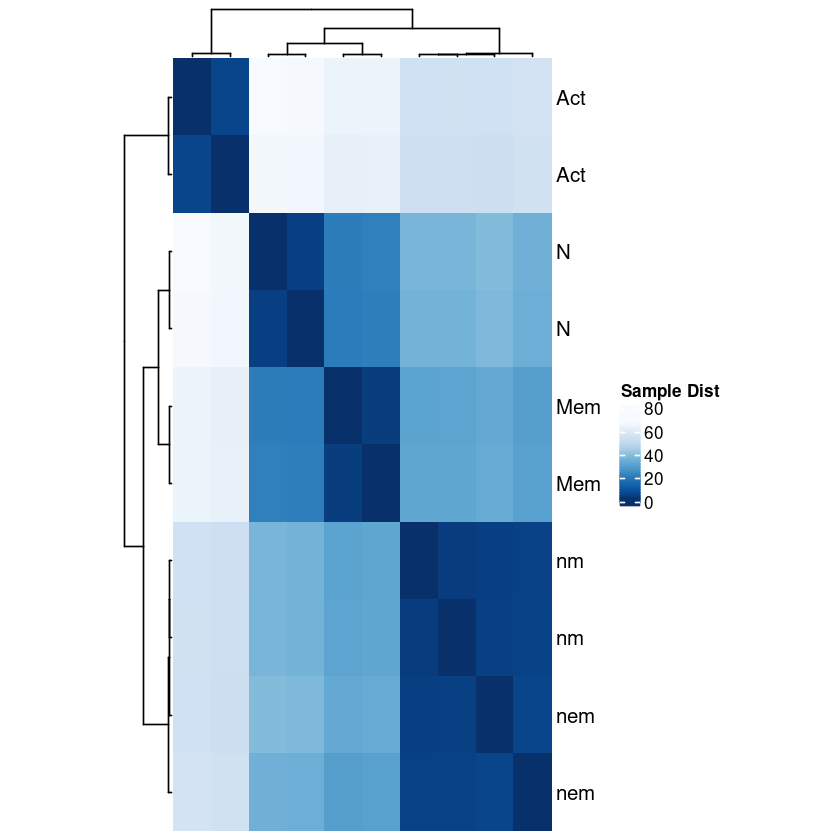

In [464]:
# choose matrix for sample distance plot
mat_dist <- rld_hm
mat_dist$cond_label <- c('Act', 'nm', 'nem', 'Act', 'nm', 'nem', 'Mem', 'N','Mem', 'N')

sampleDists <- dist(t(assay(mat_dist)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(mat_dist$cond_label, mat_dist$type)
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

ht_corr = Heatmap(sampleDistMatrix, 
    name = "Sample Dist",
    show_column_names = FALSE, 
    show_row_names = TRUE, 
    # row_names_gp = gpar(fontsize = 2), 
    cluster_columns = TRUE, 
    column_dend_reorder = c(1,8,10,1,8,10,5,3,5,3), # weights for reordering dendrogram
    cluster_rows = TRUE, 
    row_dend_reorder = c(1,8,10,1,8,10,5,3,5,3), # weights for reordering dendrogram
    show_column_dend = TRUE, show_row_dend = TRUE,width = unit(8, "cm"),
    col = colors
)
ht_corr = draw(ht_corr)

pdf("RNA_corr-matrix.pdf", width=6, height=4)
ht_corr
dev.off()

Prepare volcano plot for DE genes between populations 

In [15]:
# # Which adj p value = NA?
# hi_hi_D3.padj.na <- dat1[which(is.na(dat1$hi_hi_D3.padj)), ]$gene
# # are any of these p value = NA genes in lists of genes of interest?
# hi_hi_D3.padj.na[which(EffvMem_UP %in% hi_hi_D3.padj.na)]
# hi_hi_D3.padj.na[which(EffvMem_DN %in% hi_hi_D3.padj.na)]
# # nothing recognizable... for now, remove these na padj genes from volcano plot analysis

# Which adj p value = NA?
low_hi_hi_hi.padj.na <- dat1[which(is.na(dat1$low_hi_hi_hi.padj)), ]$gene
dat1[which(is.na(dat1$low_hi_hi_hi.padj)), ]$gene
# are any of these p value = NA genes in lists of genes of interest?
low_hi_hi_hi.padj.na[which(EffvMem_UP %in% low_hi_hi_hi.padj.na)]
low_hi_hi_hi.padj.na[which(EffvMem_DN %in% low_hi_hi_hi.padj.na)]
# nothing recognizable... for now, remove these na padj genes from volcano plot analysis


character(0)

character(0)

character(0)

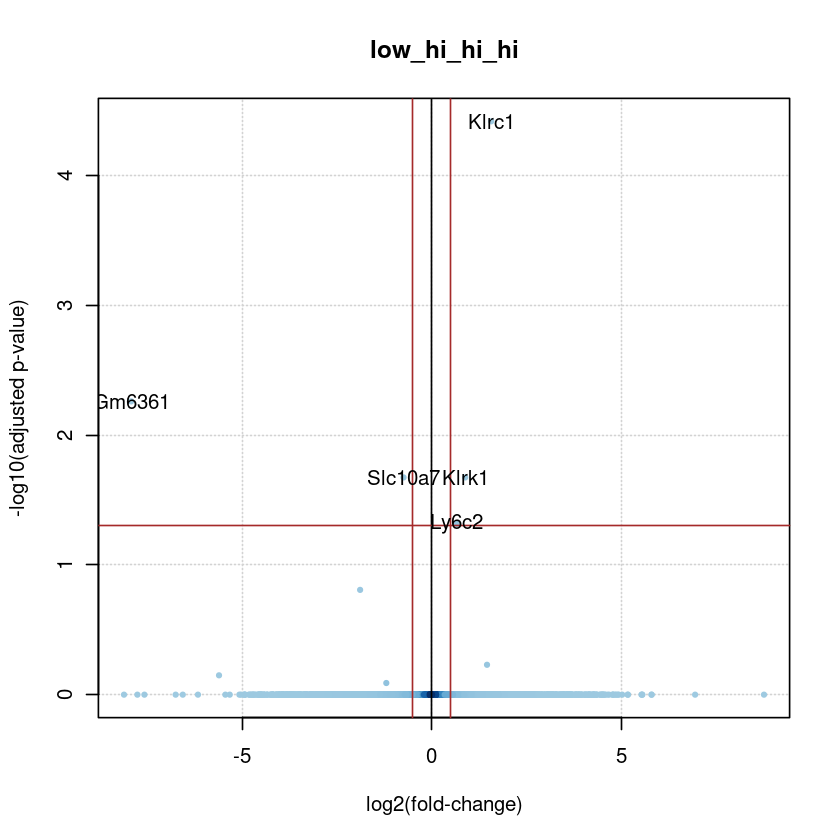

In [16]:


# # hi_hi vs. D3
# dat1_sel = dat1[which(!is.na(dat1$hi_hi_D3.padj)), ]
# FC = dat1_sel$hi_hi_D3.log2FoldChange
# p = -log10(dat1_sel$hi_hi_D3.padj)
# title = "hi_hi_D3"

# low_hi vs. hi_hi
dat1_sel = dat1[which(!is.na(dat1$low_hi_hi_hi.padj)), ]
FC = dat1_sel$low_hi_hi_hi.log2FoldChange
p = -log10(dat1_sel$low_hi_hi_hi.padj)
title = "low_hi_hi_hi"

# # low_low vs. hi_hi
# dat1_sel = dat1[which(!is.na(dat1$low_low_hi_hi.padj)), ]
# FC = dat1_sel$low_low_hi_hi.log2FoldChange
# p = -log10(dat1_sel$low_low_hi_hi.padj)
# title = "low_low_hi_hi"



alpha <- 0.05 # Threshold on the adjusted p-value
cols <- densCols(FC, p)
plot(FC, p, col=cols, panel.first=grid(),
     main=title, xlab="log2(fold-change)", ylab="-log10(adjusted p-value)",
     pch=20, cex=0.6)
abline(v=0)
abline(v=c(-.5,.5), col="brown")
abline(h=-log10(alpha), col="brown")

gn.selected <- abs(FC) > .5 & p > -log10(alpha) 
text(FC[gn.selected],
     p[gn.selected],
     lab=rownames(dat1_sel)[gn.selected ], cex=1)

GSEA analysis

In [112]:
unique(msig_df_sel$gs_name)

[1] "GOLDRATH_EFF_VS_MEMORY_CD8_TCELL_DN"                          
 [2] "GOLDRATH_EFF_VS_MEMORY_CD8_TCELL_UP"                          
 [3] "GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_DN"                           
 [4] "GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_UP"                           
 [5] "GOLDRATH_NAIVE_VS_MEMORY_CD8_TCELL_DN"                        
 [6] "GOLDRATH_NAIVE_VS_MEMORY_CD8_TCELL_UP"                        
 [7] "GSE23321_CD8_STEM_CELL_MEMORY_VS_CENTRAL_MEMORY_CD8_TCELL_DN" 
 [8] "GSE23321_CD8_STEM_CELL_MEMORY_VS_CENTRAL_MEMORY_CD8_TCELL_UP" 
 [9] "GSE23321_CD8_STEM_CELL_MEMORY_VS_EFFECTOR_MEMORY_CD8_TCELL_DN"
[10] "GSE23321_CD8_STEM_CELL_MEMORY_VS_EFFECTOR_MEMORY_CD8_TCELL_UP"
[11] "KAECH_DAY15_EFF_VS_MEMORY_CD8_TCELL_DN"                       
[12] "KAECH_DAY15_EFF_VS_MEMORY_CD8_TCELL_UP"                       
[13] "KAECH_DAY8_EFF_VS_DAY15_EFF_CD8_TCELL_DN"                     
[14] "KAECH_DAY8_EFF_VS_DAY15_EFF_CD8_TCELL_UP"                     
[15] "KAECH_DAY8_EFF_VS_MEMORY_CD8_TCELL_DN"                        
[16] "KAECH_DAY8_EFF_VS_MEMORY_CD8_TCELL_UP"                        
[17] "KAECH_NAIVE_VS_DAY15_EFF_CD8_TCELL_DN"                        
[18] "KAECH_NAIVE_VS_DAY15_EFF_CD8_TCELL_UP"                        
[19] "KAECH_NAIVE_VS_DAY8_EFF_CD8_TCELL_DN"                         
[20] "KAECH_NAIVE_VS_DAY8_EFF_CD8_TCELL_UP"                         
[21] "KAECH_NAIVE_VS_MEMORY_CD8_TCELL_DN"                           
[22] "KAECH_NAIVE_VS_MEMORY_CD8_TCELL_UP"

In [130]:
# take subset of gene lists to perform GSEA for 
msig_df_sel <- msig_df[which(msig_df$gs_name %in% gs_names_gsea), ]

# gsea
msig_list = split(x = msig_df_sel$gene_symbol, f = msig_df_sel$gs_name)


# generate ranks from test statistic
dat1_gsea <- dat1_D9_c # for analysis, use only DE genes between D9 and controls
dat1_rank <- dat1_gsea[, grep("stat", colnames(dat1_gsea))]  # first get all test statistic columns

# stat for all comparisons of interest
# compare D9 to D3
ranks_low_hi_D3 <- deframe(data.frame(gene = rownames(dat1_rank), stat = dat1_rank$low_hi_D3.stat))
ranks_hi_hi_D3 <- deframe(data.frame(gene = rownames(dat1_rank), stat = dat1_rank$hi_hi_D3.stat))
# compare D9 to D0 Ag
ranks_low_hi_Ag <- deframe(data.frame(gene = rownames(dat1_rank), stat = dat1_rank$low_hi_Ag.stat))
ranks_hi_hi_Ag <- deframe(data.frame(gene = rownames(dat1_rank), stat = dat1_rank$hi_hi_Ag.stat))

# add comparison label column
gsea_low_hi_D3 <- fgsea(pathways = msig_list, stats=ranks_low_hi_D3) %>% add_column(comp = 'LH_D3')
gsea_hi_hi_D3 <- fgsea(pathways = msig_list, stats=ranks_hi_hi_D3)%>% add_column(comp = 'HH_D3')

gsea_low_hi_Ag <- fgsea(pathways = msig_list, stats=ranks_low_hi_Ag) %>% add_column(comp = 'LH_Ag')
gsea_hi_hi_Ag <- fgsea(pathways = msig_list, stats=ranks_hi_hi_Ag) %>% add_column(comp = 'HH_Ag')



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arb

NULL

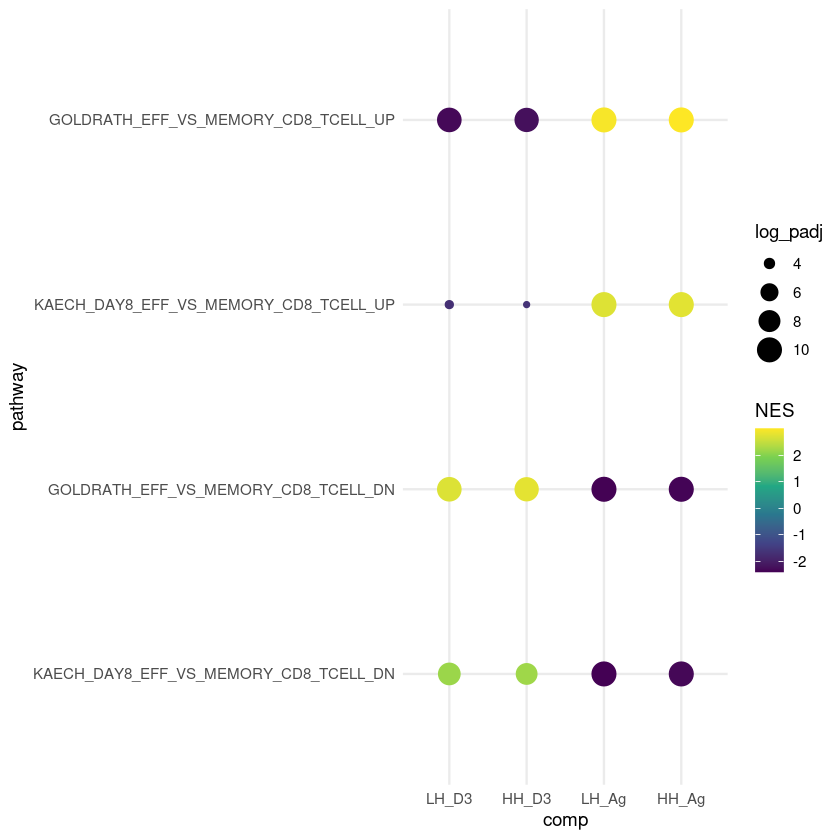

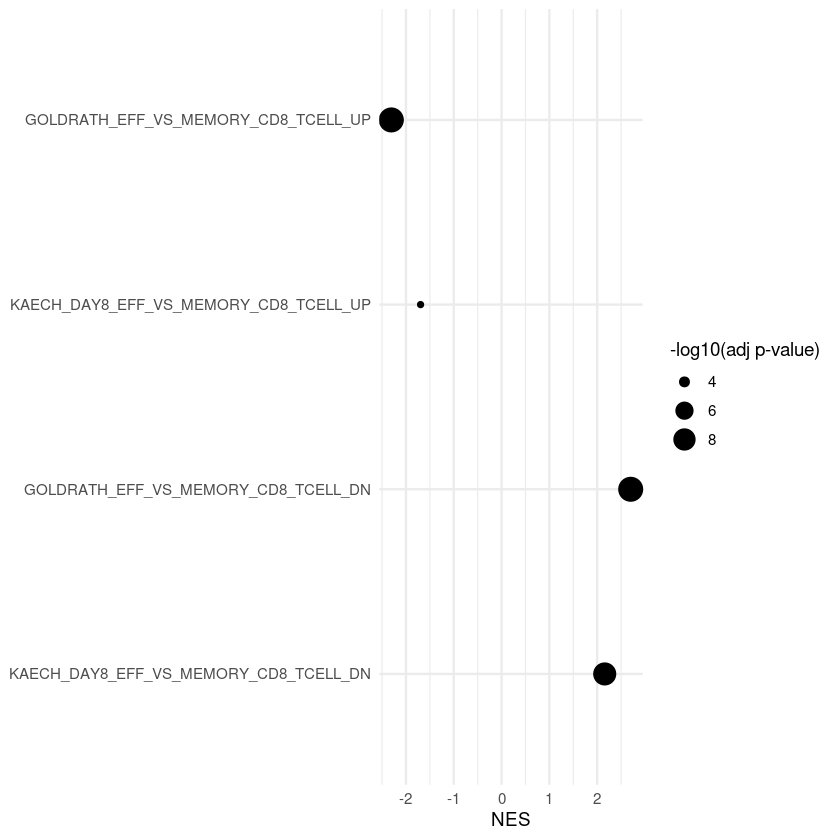

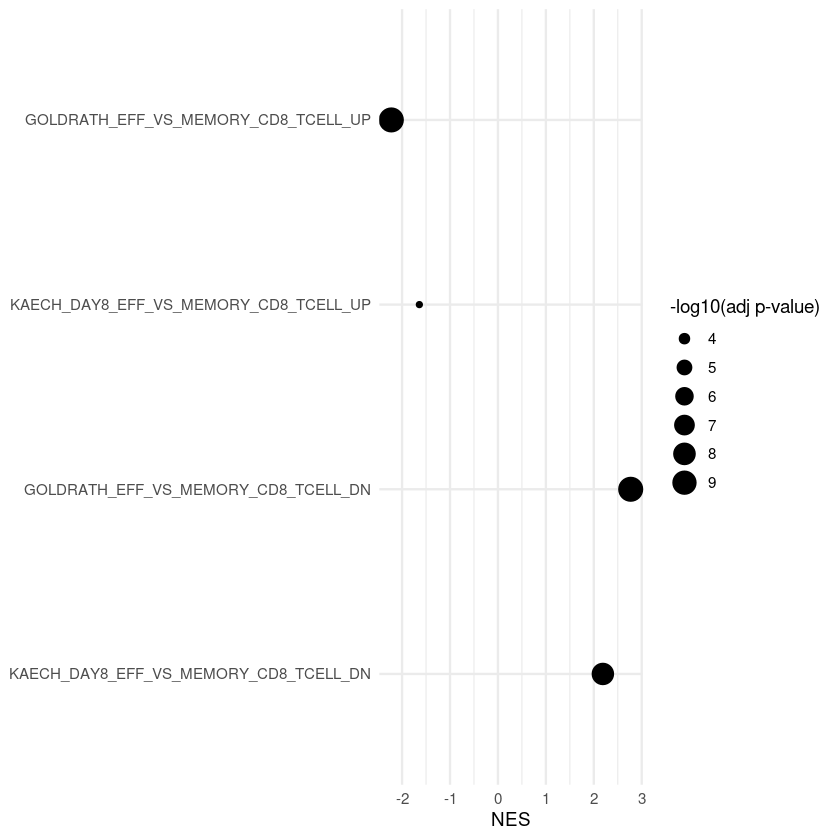

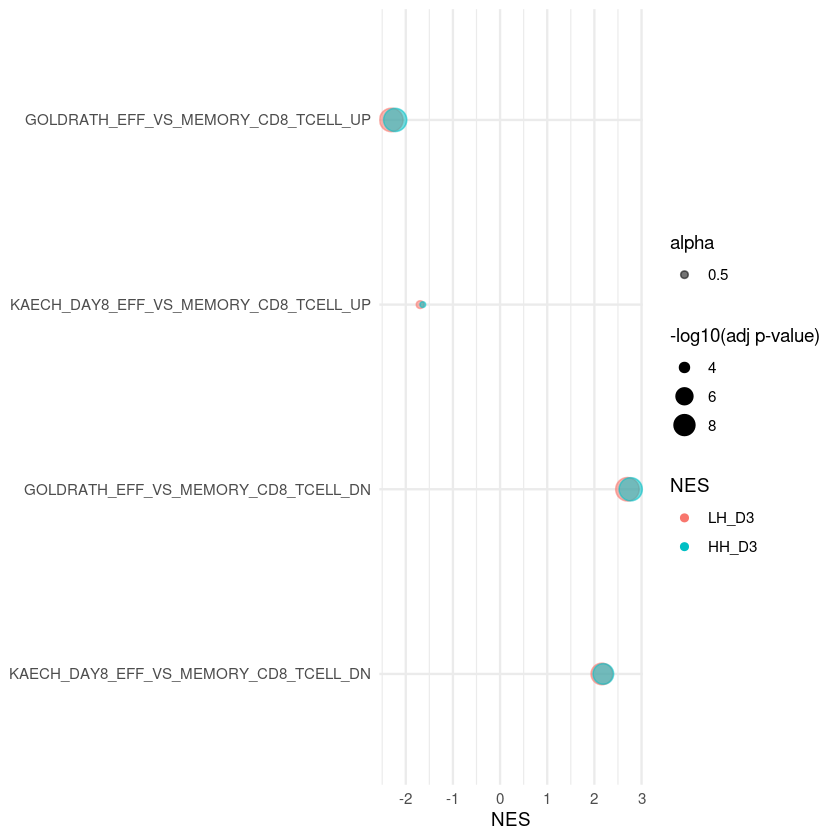

In [268]:
gsea_all <- rbind(
                  gsea_low_hi_D3,
                  gsea_hi_hi_D3,
                  gsea_low_hi_Ag,
                  gsea_hi_hi_Ag
                 )

gsea_res_tidy <- gsea_all %>%
#     filter(padj<0.05) %>%
    as_tibble() %>%
    mutate(log_padj = -log10(padj))

# order pathways by factor levels
gsea_res_tidy$pathway <- factor(gsea_res_tidy$pathway, levels = c("KAECH_DAY8_EFF_VS_MEMORY_CD8_TCELL_DN",
    "GOLDRATH_EFF_VS_MEMORY_CD8_TCELL_DN",
     "KAECH_DAY8_EFF_VS_MEMORY_CD8_TCELL_UP",
                                                                  "GOLDRATH_EFF_VS_MEMORY_CD8_TCELL_UP"))
                                                                
                                                                  

# order comparisons by factor levels 
gsea_res_tidy$comp <- factor(gsea_res_tidy$comp, levels = c(
                                                           "LH_D3",
                                                           "HH_D3",
                                                           "LH_Ag",
                                                           "HH_Ag"))


 # Plot multiple comparisons at once                                                               
gsea_plot <- gsea_res_tidy %>% ggplot(., aes(comp, pathway)) +
geom_point(aes(size = log_padj, color = NES))+
    theme_minimal() + 
    scale_color_viridis_c()
#     scale_color_gradient2(low = "blue", mid = "white",
#                             high = "red") +
labs(size = "-log10(adj p-value)", color = "NES") +
theme(axis.title.x=element_blank(), axis.title.y=element_blank()) 

# plot single comparison
gsea_plot_LH <- gsea_res_tidy %>% filter(comp == "LH_D3") %>%
 ggplot(., aes(NES, pathway)) +
geom_point(aes(size = log_padj))+
    theme_minimal() + 
labs(size = "-log10(adj p-value)", color = "NES") +
theme(axis.title.y=element_blank()) 

# plot single comparison
gsea_plot_HH <- gsea_res_tidy %>% filter(comp == "HH_D3") %>%
 ggplot(., aes(NES, pathway)) +
geom_point(aes(size = log_padj))+
    theme_minimal() + 
labs(size = "-log10(adj p-value)", color = "NES") +
theme(axis.title.y=element_blank()) 

# plot LH and HH together
gsea_plot_LH_HH <- gsea_res_tidy %>% filter(comp %in% c("LH_D3","HH_D3")) %>%
 ggplot(., aes(NES, pathway)) +
geom_point(aes(size = log_padj, color = comp, alpha = .5))+
    theme_minimal() + 
labs(size = "-log10(adj p-value)", color = "NES") +
theme(axis.title.y=element_blank()) 

gsea_plot
gsea_plot_LH
gsea_plot_HH
gsea_plot_LH_HH



In [269]:
save_plot(gsea_plot, file = "gsea_all_v2.pdf", base_width = 10)
save_plot(gsea_plot_LH, file = "gsea_all_v3_LH.pdf", base_width = 8)
save_plot(gsea_plot_HH, file = "gsea_all_v3_HH.pdf", base_width = 8)
save_plot(gsea_plot_LH_HH, file = "gsea_all_v3_LH_HH.pdf", base_width = 8)


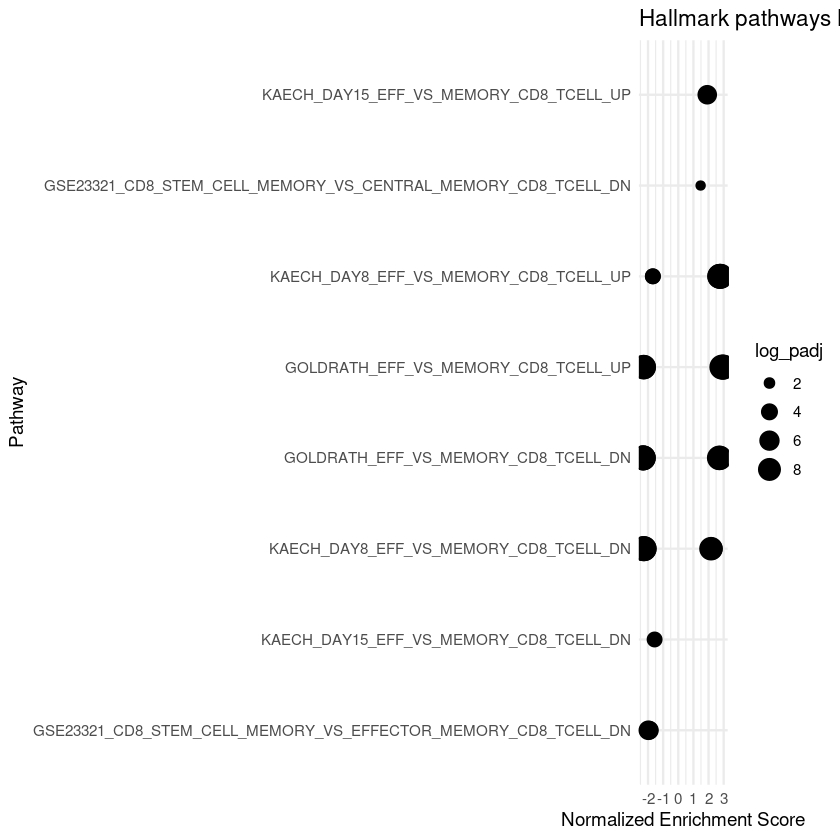

In [123]:
ggplot(gsea_res_tidy, aes(reorder(pathway, NES), NES)) +
geom_point(aes(size = log_padj))+
coord_flip()+
    labs(x="Pathway", y="Normalized Enrichment Score",
         title="Hallmark pathways NES from GSEA") +
    theme_minimal() 

In [ ]:
g <- "Ly6c2"
c <- c("hi_hi", "low_hi", "low_low", "Naive", "Ag", "D3") # categories


# Subset mat by gene and population of interest
r <- which(rownames(mat)==g)
mat_p <- as.data.frame(mat)
mat_p <- mat_p[r, ]

In [ ]:
mat_p



t <- grep("hi_hi", colnames(mat_p))
t